# Link Prediction on Cora

In [11]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

dataset = Planetoid("./", name='Cora', transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Processing...
Done!


Epoch: 001, Loss: 0.6930, Val: 0.6833, Test: 0.7031
Epoch: 002, Loss: 0.6833, Val: 0.6812, Test: 0.6972
Epoch: 003, Loss: 0.7039, Val: 0.6885, Test: 0.7066
Epoch: 004, Loss: 0.6784, Val: 0.6980, Test: 0.7239
Epoch: 005, Loss: 0.6852, Val: 0.7068, Test: 0.7394
Epoch: 006, Loss: 0.6878, Val: 0.7131, Test: 0.7451
Epoch: 007, Loss: 0.6883, Val: 0.7073, Test: 0.7348
Epoch: 008, Loss: 0.6870, Val: 0.6965, Test: 0.7197
Epoch: 009, Loss: 0.6830, Val: 0.6891, Test: 0.7076
Epoch: 010, Loss: 0.6761, Val: 0.6857, Test: 0.6987
Epoch: 011, Loss: 0.6698, Val: 0.6835, Test: 0.6920
Epoch: 012, Loss: 0.6734, Val: 0.6832, Test: 0.6921
Epoch: 013, Loss: 0.6685, Val: 0.6930, Test: 0.7060
Epoch: 014, Loss: 0.6586, Val: 0.7174, Test: 0.7335
Epoch: 015, Loss: 0.6553, Val: 0.7420, Test: 0.7504
Epoch: 016, Loss: 0.6487, Val: 0.7464, Test: 0.7467
Epoch: 017, Loss: 0.6378, Val: 0.7380, Test: 0.7356
Epoch: 018, Loss: 0.6248, Val: 0.7408, Test: 0.7335
Epoch: 019, Loss: 0.6165, Val: 0.7703, Test: 0.7496
Epoch: 020, 

# Link Prediction on Senators

In [16]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
# from models.GLASE_unshared_normalized_v2 import gLASE_v2
import matplotlib.pyplot as plt

torch.manual_seed(42)

d = 4
n_P1 = 100
n_P2 = 80
n_L1 = 100
n_L2 = 100
n_L3 = 30

P1_L1 = 0.9
P1_L2 = 0.01
P1_L3 = 0.2  
P2_L1 = 0.1
P2_L2 = 0.8
P2_L3 = 0.3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 80
n_P2_np = 60
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.1).int()
    mask[i,:] = votos
    mask[:,i] = votos


## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)


torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)


x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(49.1557)


In [17]:
gd_steps = 10
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 1000

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)


tensor(63.5190, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51.3135, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(50.3738, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(50.3378, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(50.2794, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(50.3385, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(50.1427, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(50.2505, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(50.2009, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(50.1332, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


tensor(50.0269, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


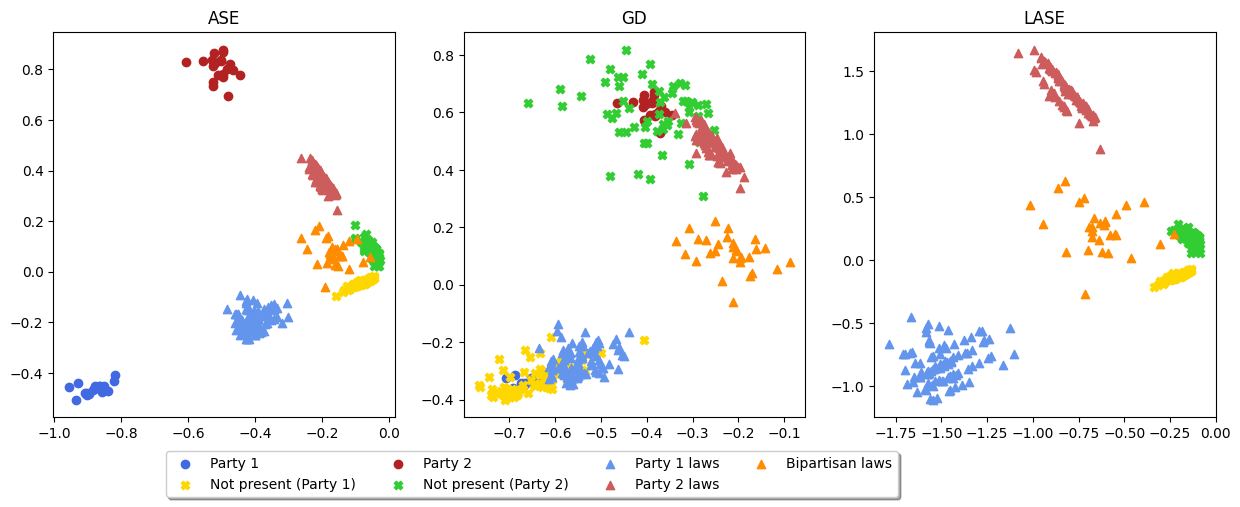

In [18]:
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')


fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

# Label features

In [19]:
## Node features -- One hot encoding of label P1, P2, L1, L2, L3

import torch.nn.functional as F

labels = np.concatenate((np.ones(n_P1)*0,np.ones(n_P2), np.ones(n_L1)*2, np.ones(n_L2)*3, np.ones(n_L3)*4))
labels = labels.tolist()
labels = torch.tensor(labels).long()
labels = F.one_hot(labels)



labels.shape

torch.Size([410, 5])

In [8]:
## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=labels.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)

transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


train_data, val_data, test_data = transform(data)

## GCN embeddings

In [9]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(5, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6929, Val: 0.9109, Test: 0.8962
Epoch: 002, Loss: 0.6478, Val: 0.9019, Test: 0.8843
Epoch: 003, Loss: 0.6156, Val: 0.8797, Test: 0.8647
Epoch: 004, Loss: 0.5787, Val: 0.8749, Test: 0.8593
Epoch: 005, Loss: 0.5600, Val: 0.8679, Test: 0.8514
Epoch: 006, Loss: 0.5605, Val: 0.8743, Test: 0.8544
Epoch: 007, Loss: 0.5578, Val: 0.8743, Test: 0.8550
Epoch: 008, Loss: 0.5525, Val: 0.8749, Test: 0.8539
Epoch: 009, Loss: 0.5431, Val: 0.8783, Test: 0.8548
Epoch: 010, Loss: 0.5413, Val: 0.8799, Test: 0.8563
Epoch: 011, Loss: 0.5432, Val: 0.8802, Test: 0.8560
Epoch: 012, Loss: 0.5417, Val: 0.8797, Test: 0.8549
Epoch: 013, Loss: 0.5385, Val: 0.8801, Test: 0.8561
Epoch: 014, Loss: 0.5393, Val: 0.8794, Test: 0.8570
Epoch: 015, Loss: 0.5390, Val: 0.8795, Test: 0.8571
Epoch: 016, Loss: 0.5385, Val: 0.8787, Test: 0.8565
Epoch: 017, Loss: 0.5346, Val: 0.8772, Test: 0.8560
Epoch: 018, Loss: 0.5390, Val: 0.8771, Test: 0.8560
Epoch: 019, Loss: 0.5334, Val: 0.8769, Test: 0.8562
Epoch: 020, 

In [10]:
## Predict on entire masked graph

z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')

In [11]:
adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [12]:
adj_matrix[senadores_no_presentes][:,n_P1+n_P2:].shape

torch.Size([48, 230])

In [13]:
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / 48 / 230

tensor(0.8604)

## ASE embeddings

In [14]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_ase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6901, Val: 0.8946, Test: 0.8835
Epoch: 002, Loss: 0.6330, Val: 0.8840, Test: 0.8689
Epoch: 003, Loss: 0.5941, Val: 0.8782, Test: 0.8613
Epoch: 004, Loss: 0.5537, Val: 0.8779, Test: 0.8574
Epoch: 005, Loss: 0.5509, Val: 0.8788, Test: 0.8562
Epoch: 006, Loss: 0.5619, Val: 0.8800, Test: 0.8563
Epoch: 007, Loss: 0.5363, Val: 0.8796, Test: 0.8552
Epoch: 008, Loss: 0.5334, Val: 0.8782, Test: 0.8540
Epoch: 009, Loss: 0.5376, Val: 0.8797, Test: 0.8558
Epoch: 010, Loss: 0.5494, Val: 0.8797, Test: 0.8570
Epoch: 011, Loss: 0.5422, Val: 0.8789, Test: 0.8572
Epoch: 012, Loss: 0.5431, Val: 0.8784, Test: 0.8570
Epoch: 013, Loss: 0.5417, Val: 0.8780, Test: 0.8573
Epoch: 014, Loss: 0.5347, Val: 0.8786, Test: 0.8566
Epoch: 015, Loss: 0.5312, Val: 0.8794, Test: 0.8560
Epoch: 016, Loss: 0.5382, Val: 0.8796, Test: 0.8557
Epoch: 017, Loss: 0.5344, Val: 0.8797, Test: 0.8557
Epoch: 018, Loss: 0.5309, Val: 0.8791, Test: 0.8561
Epoch: 019, Loss: 0.5350, Val: 0.8791, Test: 0.8569
Epoch: 020, 

In [15]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / 48 / 230

tensor(0.8276)

## GLASE embeddings

In [16]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.9126, Val: 0.7181, Test: 0.6946
Epoch: 002, Loss: 0.6863, Val: 0.7589, Test: 0.7235
Epoch: 003, Loss: 0.6503, Val: 0.7725, Test: 0.7417
Epoch: 004, Loss: 0.6319, Val: 0.8122, Test: 0.7988
Epoch: 005, Loss: 0.6119, Val: 0.8434, Test: 0.8359
Epoch: 006, Loss: 0.5813, Val: 0.8629, Test: 0.8494
Epoch: 007, Loss: 0.5719, Val: 0.8715, Test: 0.8499
Epoch: 008, Loss: 0.5638, Val: 0.8738, Test: 0.8505
Epoch: 009, Loss: 0.5510, Val: 0.8760, Test: 0.8530
Epoch: 010, Loss: 0.5423, Val: 0.8796, Test: 0.8566
Epoch: 011, Loss: 0.5639, Val: 0.8812, Test: 0.8583
Epoch: 012, Loss: 0.5478, Val: 0.8813, Test: 0.8579
Epoch: 013, Loss: 0.5420, Val: 0.8809, Test: 0.8573
Epoch: 014, Loss: 0.5383, Val: 0.8801, Test: 0.8570
Epoch: 015, Loss: 0.5342, Val: 0.8792, Test: 0.8572
Epoch: 016, Loss: 0.5366, Val: 0.8786, Test: 0.8566
Epoch: 017, Loss: 0.5367, Val: 0.8778, Test: 0.8558
Epoch: 018, Loss: 0.5422, Val: 0.8770, Test: 0.8547
Epoch: 019, Loss: 0.5379, Val: 0.8755, Test: 0.8547
Epoch: 020, 

In [17]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / 48 / 230

tensor(0.8653)

# Random features

In [20]:
torch.manual_seed(42)
random_features=torch.rand([410, 5])
random_features

tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        ...,
        [0.1418, 0.3650, 0.0908, 0.6902, 0.8538],
        [0.5396, 0.1421, 0.1213, 0.3054, 0.6454],
        [0.5122, 0.5909, 0.9712, 0.7322, 0.6075]])

In [21]:
## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)

transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


train_data, val_data, test_data = transform(data)

## GCN Embeddings

In [22]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(5, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6953, Val: 0.7959, Test: 0.7682
Epoch: 002, Loss: 0.6734, Val: 0.7978, Test: 0.7710
Epoch: 003, Loss: 0.6809, Val: 0.7980, Test: 0.7714
Epoch: 004, Loss: 0.6712, Val: 0.7983, Test: 0.7721
Epoch: 005, Loss: 0.6708, Val: 0.7985, Test: 0.7726
Epoch: 006, Loss: 0.6709, Val: 0.7992, Test: 0.7731
Epoch: 007, Loss: 0.6690, Val: 0.7995, Test: 0.7734
Epoch: 008, Loss: 0.6676, Val: 0.7998, Test: 0.7736
Epoch: 009, Loss: 0.6663, Val: 0.8001, Test: 0.7738
Epoch: 010, Loss: 0.6657, Val: 0.8005, Test: 0.7740
Epoch: 011, Loss: 0.6627, Val: 0.8008, Test: 0.7741
Epoch: 012, Loss: 0.6600, Val: 0.8007, Test: 0.7739
Epoch: 013, Loss: 0.6568, Val: 0.8008, Test: 0.7739
Epoch: 014, Loss: 0.6553, Val: 0.8009, Test: 0.7737
Epoch: 015, Loss: 0.6501, Val: 0.8011, Test: 0.7737
Epoch: 016, Loss: 0.6479, Val: 0.8006, Test: 0.7735
Epoch: 017, Loss: 0.6471, Val: 0.7997, Test: 0.7727
Epoch: 018, Loss: 0.6421, Val: 0.7988, Test: 0.7720
Epoch: 019, Loss: 0.6374, Val: 0.7988, Test: 0.7714
Epoch: 020, 

In [25]:
## Predict on entire masked graph

z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230


tensor(0.5478)

## ASE Embeddings

In [26]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_ase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.7001, Val: 0.7913, Test: 0.7788
Epoch: 002, Loss: 0.6708, Val: 0.8226, Test: 0.8024
Epoch: 003, Loss: 0.6873, Val: 0.8418, Test: 0.8290
Epoch: 004, Loss: 0.6504, Val: 0.8587, Test: 0.8550
Epoch: 005, Loss: 0.6426, Val: 0.8519, Test: 0.8576
Epoch: 006, Loss: 0.6330, Val: 0.8455, Test: 0.8506
Epoch: 007, Loss: 0.6160, Val: 0.8431, Test: 0.8489
Epoch: 008, Loss: 0.5968, Val: 0.8409, Test: 0.8468
Epoch: 009, Loss: 0.5832, Val: 0.8383, Test: 0.8420
Epoch: 010, Loss: 0.5665, Val: 0.8349, Test: 0.8386
Epoch: 011, Loss: 0.5566, Val: 0.8340, Test: 0.8353
Epoch: 012, Loss: 0.5475, Val: 0.8326, Test: 0.8351
Epoch: 013, Loss: 0.5462, Val: 0.8328, Test: 0.8335
Epoch: 014, Loss: 0.5446, Val: 0.8326, Test: 0.8332
Epoch: 015, Loss: 0.5444, Val: 0.8310, Test: 0.8345
Epoch: 016, Loss: 0.5416, Val: 0.8332, Test: 0.8313
Epoch: 017, Loss: 0.5371, Val: 0.8328, Test: 0.8299
Epoch: 018, Loss: 0.5487, Val: 0.8335, Test: 0.8331
Epoch: 019, Loss: 0.5439, Val: 0.8316, Test: 0.8365
Epoch: 020, 

In [27]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230

tensor(0.8468)

## GLASE Embeddings

In [28]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.9686, Val: 0.6309, Test: 0.6366
Epoch: 002, Loss: 0.7129, Val: 0.7318, Test: 0.7346
Epoch: 003, Loss: 0.6964, Val: 0.7683, Test: 0.7674
Epoch: 004, Loss: 0.6883, Val: 0.7797, Test: 0.7852
Epoch: 005, Loss: 0.6685, Val: 0.7797, Test: 0.7873
Epoch: 006, Loss: 0.6609, Val: 0.7843, Test: 0.7932
Epoch: 007, Loss: 0.6556, Val: 0.7904, Test: 0.8046
Epoch: 008, Loss: 0.6520, Val: 0.7887, Test: 0.8063
Epoch: 009, Loss: 0.6418, Val: 0.7884, Test: 0.8054
Epoch: 010, Loss: 0.6320, Val: 0.7891, Test: 0.8052
Epoch: 011, Loss: 0.6280, Val: 0.7849, Test: 0.8025
Epoch: 012, Loss: 0.6162, Val: 0.7778, Test: 0.7982
Epoch: 013, Loss: 0.6132, Val: 0.7738, Test: 0.7937
Epoch: 014, Loss: 0.5996, Val: 0.7722, Test: 0.7913
Epoch: 015, Loss: 0.5857, Val: 0.7746, Test: 0.7917
Epoch: 016, Loss: 0.5802, Val: 0.7824, Test: 0.7988
Epoch: 017, Loss: 0.5668, Val: 0.7929, Test: 0.8070
Epoch: 018, Loss: 0.5702, Val: 0.8016, Test: 0.8142
Epoch: 019, Loss: 0.5655, Val: 0.8121, Test: 0.8240
Epoch: 020, 

In [29]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230

tensor(0.8558)

# Vector of ones

In [30]:
torch.manual_seed(42)
ones_features=torch.ones([410, 5])
ones_features

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [31]:
## Split Train, Val, Test
from torch_geometric.data import Data
import torch_geometric.transforms as T

device = 'cuda'

masked_edge_index = masked_adj.nonzero().t().contiguous()

data = Data(x=random_features.float(), x_ase=x_ase, x_glase=x_glase, edge_index=masked_edge_index)

transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


train_data, val_data, test_data = transform(data)

## GCN Embeddings

In [32]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(5, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6809, Val: 0.7945, Test: 0.7740
Epoch: 002, Loss: 0.6746, Val: 0.7971, Test: 0.7769
Epoch: 003, Loss: 0.6950, Val: 0.7963, Test: 0.7767
Epoch: 004, Loss: 0.6680, Val: 0.7958, Test: 0.7767
Epoch: 005, Loss: 0.6728, Val: 0.7960, Test: 0.7770
Epoch: 006, Loss: 0.6740, Val: 0.7967, Test: 0.7769
Epoch: 007, Loss: 0.6702, Val: 0.7971, Test: 0.7770
Epoch: 008, Loss: 0.6666, Val: 0.7976, Test: 0.7770
Epoch: 009, Loss: 0.6665, Val: 0.7977, Test: 0.7771
Epoch: 010, Loss: 0.6687, Val: 0.7976, Test: 0.7770
Epoch: 011, Loss: 0.6626, Val: 0.7970, Test: 0.7770
Epoch: 012, Loss: 0.6600, Val: 0.7965, Test: 0.7766
Epoch: 013, Loss: 0.6582, Val: 0.7964, Test: 0.7763
Epoch: 014, Loss: 0.6561, Val: 0.7963, Test: 0.7763
Epoch: 015, Loss: 0.6524, Val: 0.7970, Test: 0.7766
Epoch: 016, Loss: 0.6488, Val: 0.7971, Test: 0.7768
Epoch: 017, Loss: 0.6482, Val: 0.7968, Test: 0.7768
Epoch: 018, Loss: 0.6453, Val: 0.7962, Test: 0.7761
Epoch: 019, Loss: 0.6414, Val: 0.7954, Test: 0.7750
Epoch: 020, 

In [33]:
## Predict on entire masked graph

z = model.encode(data.x, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230


tensor(0.5545)

## ASE Embeddings

In [34]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_ase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_ase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_ase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6694, Val: 0.8427, Test: 0.8247
Epoch: 002, Loss: 0.6670, Val: 0.8461, Test: 0.8198
Epoch: 003, Loss: 0.6483, Val: 0.8730, Test: 0.8557
Epoch: 004, Loss: 0.6304, Val: 0.8706, Test: 0.8652
Epoch: 005, Loss: 0.6054, Val: 0.8490, Test: 0.8508
Epoch: 006, Loss: 0.5772, Val: 0.8428, Test: 0.8379
Epoch: 007, Loss: 0.5562, Val: 0.8371, Test: 0.8408
Epoch: 008, Loss: 0.5409, Val: 0.8396, Test: 0.8331
Epoch: 009, Loss: 0.5562, Val: 0.8187, Test: 0.8304
Epoch: 010, Loss: 0.5673, Val: 0.8372, Test: 0.8344
Epoch: 011, Loss: 0.5494, Val: 0.8351, Test: 0.8300
Epoch: 012, Loss: 0.5546, Val: 0.8293, Test: 0.8346
Epoch: 013, Loss: 0.5419, Val: 0.8241, Test: 0.8326
Epoch: 014, Loss: 0.5455, Val: 0.8312, Test: 0.8298
Epoch: 015, Loss: 0.5385, Val: 0.8334, Test: 0.8291
Epoch: 016, Loss: 0.5485, Val: 0.8347, Test: 0.8319
Epoch: 017, Loss: 0.5405, Val: 0.8370, Test: 0.8389
Epoch: 018, Loss: 0.5395, Val: 0.8387, Test: 0.8411
Epoch: 019, Loss: 0.5379, Val: 0.8420, Test: 0.8413
Epoch: 020, 

In [35]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_ase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230

tensor(0.8357)

## GLASE Embeddings

In [36]:
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling


model = Net(9, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    x_train = torch.concatenate((train_data.x, train_data.x_glase), axis=1)
    z = model.encode(x_train, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    x_test = torch.concatenate((data.x, data.x_glase), axis=1)
    z = model.encode(x_test, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

x_test = torch.concatenate((test_data.x, test_data.x_glase), axis=1)
z = model.encode(x_test, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.8382, Val: 0.6897, Test: 0.7031
Epoch: 002, Loss: 0.6994, Val: 0.7442, Test: 0.7525
Epoch: 003, Loss: 0.6994, Val: 0.7943, Test: 0.7836
Epoch: 004, Loss: 0.6782, Val: 0.8038, Test: 0.7913
Epoch: 005, Loss: 0.6596, Val: 0.8057, Test: 0.7909
Epoch: 006, Loss: 0.6519, Val: 0.7889, Test: 0.7664
Epoch: 007, Loss: 0.6490, Val: 0.7955, Test: 0.7749
Epoch: 008, Loss: 0.6417, Val: 0.8108, Test: 0.7998
Epoch: 009, Loss: 0.6352, Val: 0.8050, Test: 0.7956
Epoch: 010, Loss: 0.6222, Val: 0.7920, Test: 0.7842
Epoch: 011, Loss: 0.6096, Val: 0.7921, Test: 0.7866
Epoch: 012, Loss: 0.6048, Val: 0.8015, Test: 0.7905
Epoch: 013, Loss: 0.5982, Val: 0.8124, Test: 0.8027
Epoch: 014, Loss: 0.5842, Val: 0.8129, Test: 0.8052
Epoch: 015, Loss: 0.5827, Val: 0.8105, Test: 0.8022
Epoch: 016, Loss: 0.5685, Val: 0.8095, Test: 0.8089
Epoch: 017, Loss: 0.5680, Val: 0.8197, Test: 0.8168
Epoch: 018, Loss: 0.5601, Val: 0.8284, Test: 0.8236
Epoch: 019, Loss: 0.5519, Val: 0.8314, Test: 0.8238
Epoch: 020, 

In [37]:
## Predict on entire masked graph
x_test = torch.concatenate((data.x, data.x_glase), axis=1)
z = model.encode(x_test, data.edge_index)
final_edge_index = model.decode_all(z)


predicted_adj = to_dense_adj(final_edge_index).squeeze(0).to('cpu')
(adj_matrix[senadores_no_presentes][:,n_P1+n_P2:]==predicted_adj[senadores_no_presentes][:,n_P1+n_P2:]).sum() / (n_P1_np+n_P2_np) / 230

tensor(0.8571)